## GPU check

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# 연산에 사용한 디바이스 정보 출력 설정
tf.debugging.set_log_device_placement(True)

# 텐서 생성
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1704387392247429839
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7898612107800749447
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7052715648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16777911315889406064
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14267179244282354188
physical_device_desc: "device: XLA_GPU device"
]
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## import

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import keras
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.applications import VGG16

## Data load

In [3]:
dataset = pd.read_csv("D:/KimSK/NIPA/train/train.tsv", delimiter='\t', header=None)
dataset.columns = ['plant_disease_index', 'plant','disease']
data = dataset.copy()
print(dataset)

      plant_disease_index  plant  disease
0            3_5_1123.jpg      3        5
1           3_20_1048.jpg      3       20
2             4_2_401.jpg      4        2
3             4_7_740.jpg      4        7
4             4_11_93.jpg      4       11
...                   ...    ...      ...
15995      13_15_1600.jpg     13       15
15996      13_16_1570.jpg     13       16
15997       13_17_986.jpg     13       17
15998      13_18_4980.jpg     13       18
15999       13_20_282.jpg     13       20

[16000 rows x 3 columns]


In [4]:
data['plant_str'] = data[['plant']].astype(str)
data['disease_str'] = data[['disease']].astype(str)
data['sub'] = data['plant_str'] + '_' + data['disease_str']
data

,plant_disease_index,plant,disease,plant_str,disease_str,sub
0,3_5_1123.jpg,3,5,3,5,3_5
1,3_20_1048.jpg,3,20,3,20,3_20
2,4_2_401.jpg,4,2,4,2,4_2
3,4_7_740.jpg,4,7,4,7,4_7
4,4_11_93.jpg,4,11,4,11,4_11
...,...,...,...,...,...,...
15995,13_15_1600.jpg,13,15,13,15,13_15
15996,13_16_1570.jpg,13,16,13,16,13_16
15997,13_17_986.jpg,13,17,13,17,13_17
15998,13_18_4980.jpg,13,18,13,18,13_18


In [5]:
data.groupby('sub').count()

,plant_disease_index,plant,disease,plant_str,disease_str
sub,,,,,
10_20,800,800,800,800,800
11_14,800,800,800,800,800
13_1,800,800,800,800,800
13_15,800,800,800,800,800
13_16,800,800,800,800,800
13_17,800,800,800,800,800
13_18,800,800,800,800,800
13_20,800,800,800,800,800
13_6,800,800,800,800,800


In [6]:
train, test = train_test_split(data,stratify=data['sub'], test_size=0.2)
print('train shape : ',train.shape, 'test shape : ',test.shape)

train shape :  (12800, 6) test shape :  (3200, 6)


In [7]:
train, valid = train_test_split(train,stratify=train['sub'], test_size=0.2)
print('train shape : ',train.shape, 'valid shape : ',valid.shape)

train shape :  (10240, 6) valid shape :  (2560, 6)


In [8]:
train = train[['plant_disease_index','plant','disease']]
valid = valid[['plant_disease_index','plant','disease']]
test = test[['plant_disease_index','plant','disease']]

In [9]:
train_path = "D:/KimSK/NIPA/train"

## image preprocessing

In [10]:
trainGen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        shear_range=0.2,
                                                        zoom_range=0.2,
                                                        fill_mode='nearest')

In [11]:
train_generator = trainGen.flow_from_dataframe(
    train,                 #dataframe 
    #directory=train_folder, #root directory (current path) 
    directory=train_path,     #Root directory (current path) 
    x_col='plant_disease_index',
    y_col= ['plant','disease'],
    target_size=(224, 224),
    batch_size=32,
    seed=3,
    shuffle=True,
    class_mode='multi_output',)

Found 10240 validated image filenames.


In [12]:
validGen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
valid_generator = validGen.flow_from_dataframe(
    valid,                 #dataframe 
    #directory=train_folder, #root directory (current path) 
    directory=train_path,     #Root directory (current path) 
    x_col='plant_disease_index',
    y_col=['plant','disease'],
    target_size=(224, 224),
    batch_size=32,
    seed=3,
    shuffle=False,
    class_mode='multi_output',)

Found 2560 validated image filenames.


In [14]:
testGen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [15]:
test_generator = testGen.flow_from_dataframe(
    test,                 #dataframe 
    #directory=train_folder, #root directory (current path) 
    directory=train_path,     #Root directory (current path) 
    x_col='plant_disease_index',
    y_col=['plant','disease'],
    target_size=(224, 224),
    batch_size=32,
    seed=3,
    shuffle=False,
    class_mode='multi_output',)

Found 3200 validated image filenames.


In [16]:
### GPU check
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [17]:
### GPU check
tf.config.list_physical_devices('GPU')

tf.test.gpu_device_name()

'/device:GPU:0'

In [18]:
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num)
print(valid_num)

10240
2560


## callback

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(30, 32)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

## model

In [20]:
with tf.device('/GPU:0'):
    input_img = keras.layers.Input(shape=(224, 224, 3), name='plant_disease_index',dtype='float32')

    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))(input_img)

    x = keras.layers.Flatten()(conv_base)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    output1 = keras.layers.Dense(14, activation='softmax', name='plant')(x)
    output2 = keras.layers.Dense(21, activation='softmax', name='disease')(x)
    
    conv_base.trainable = False
    model = keras.models.Model(input_img, [output1,output2])
    
    model.compile(optimizer='adam', loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"], 
                  metrics=['acc'])
    
    history = model.fit_generator(train_generator, steps_per_epoch=train_num//32, validation_data=valid_generator,
                              validation_steps=valid_num//32, epochs=50, callbacks=[checkpoint, earlystopping])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00005: val_loss improved from 2.02856 to 1.90518, saving model to checkpoint-epoch-30-batch-32-trial-001.h5
320/320 [==============================] - 144s 451ms/step - loss: 2.1514 - plant_loss: 0.7992 - disease_loss: 1.3523 - plant_acc: 0.7065 - disease_acc: 0.4943 - val_loss: 1.9052 - val_plant_loss: 0.6824 - val_disease_loss: 1.2228 - val_plant_acc: 0.7348 - val_disease_acc: 0.5359
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDatas

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00011: val_loss improved from 1.35615 to 1.13012, saving model to checkpoint-epoch-30-batch-32-trial-001.h5
320/320 [==============================] - 139s 433ms/step - loss: 1.4515 - plant_loss: 0.5023 - disease_loss: 0.9493 - plant_acc: 0.8093 - disease_acc: 0.6394 - val_loss: 1.1301 - val_plant_loss: 0.3806 - val_disease_loss: 0.7495 - val_plant_acc: 0.8566 - val_disease_acc: 0.7223
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 12/50
320/320 [==============================] - ETA: 0s - loss: 1.3887 - plant_loss: 0.4785 - disease_loss: 0.9101 - plant_acc: 0.8173 - disease_acc: 0.6705Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset i

Epoch 18/50
320/320 [==============================] - ETA: 0s - loss: 0.9679 - plant_loss: 0.3210 - disease_loss: 0.6469 - plant_acc: 0.8833 - disease_acc: 0.7775Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00018: val_loss improved from 0.87235 to 0.83328, saving model to checkpoint-epoch-30-batch-32-trial-001.h5
320/320 [==============================] - 147s 459ms/step - loss: 0.9679 - plant_loss: 0.3210 - disease_loss: 0.6469 - plant_acc: 0.8833 - dis

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00024: val_loss did not improve from 0.55599
320/320 [==============================] - 141s 441ms/step - loss: 0.7128 - plant_loss: 0.2326 - disease_loss: 0.4802 - plant_acc: 0.9159 - disease_acc: 0.8415 - val_loss: 0.5620 - val_plant_loss: 0.1682 - val_disease_loss: 0.3937 - val_plant_acc: 0.9379 - val_disease_acc: 0.8656
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 25/50
320/320 [==============================] - ETA: 0s - loss: 0.6911 - plant_loss: 0.2196 - disease_loss: 0.4715 - plant_acc: 0.9263 - disease_acc: 0.8455Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

320/320 [==============================] - ETA: 0s - loss: 0.6639 - plant_loss: 0.2184 - disease_loss: 0.4454 - plant_acc: 0.9220 - disease_acc: 0.8546Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00031: val_loss improved from 0.48555 to 0.43317, saving model to checkpoint-epoch-30-batch-32-trial-001.h5
320/320 [==============================] - 147s 459ms/step - loss: 0.6639 - plant_loss: 0.2184 - disease_loss: 0.4454 - plant_acc: 0.9220 - disease_acc: 0.

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00037: val_loss did not improve from 0.39154
320/320 [==============================] - 137s 427ms/step - loss: 0.6285 - plant_loss: 0.2078 - disease_loss: 0.4207 - plant_acc: 0.9288 - disease_acc: 0.8672 - val_loss: 0.4486 - val_plant_loss: 0.1337 - val_disease_loss: 0.3149 - val_plant_acc: 0.9473 - val_disease_acc: 0.8898
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 38/50
320/320 [==============================] - ETA: 0s - loss: 0.5903 - plant_loss: 0.1967 - disease_loss: 0.3936 - plant_acc: 0.9341 - disease_acc: 0.8732Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

320/320 [==============================] - ETA: 0s - loss: 1.2007 - plant_loss: 0.4350 - disease_loss: 0.7657 - plant_acc: 0.8633 - disease_acc: 0.7622Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00044: val_loss did not improve from 0.38135
320/320 [==============================] - 136s 425ms/step - loss: 1.2007 - plant_loss: 0.4350 - disease_loss: 0.7657 - plant_acc: 0.8633 - disease_acc: 0.7622 - val_loss: 0.8270 - val_plant_loss: 0.2654 - val_disease_

### history

In [21]:
data_history = pd.DataFrame(history.history)
data_history.tail(10)

,loss,plant_loss,disease_loss,plant_acc,disease_acc,val_loss,val_plant_loss,val_disease_loss,val_plant_acc,val_disease_acc
40,0.620242,0.213320,0.406922,0.931055,0.876562,0.506320,0.174345,0.331975,0.938672,0.887891
41,0.588985,0.201870,0.387115,0.928027,0.875977,0.641367,0.237331,0.404036,0.925781,0.887500
42,2.184179,0.832039,1.352141,0.809473,0.671582,0.828216,0.247674,0.580543,0.900781,0.798437
43,1.200685,0.434957,0.765727,0.863281,0.762207,0.826996,0.265432,0.561564,0.899219,0.809375
44,0.793403,0.276896,0.516507,0.899121,0.828320,0.839364,0.277845,0.561520,0.901172,0.819141
45,0.675877,0.223958,0.451918,0.922266,0.852930,0.454925,0.145450,0.309475,0.940625,0.892969
46,0.701788,0.243969,0.457819,0.915527,0.853516,0.534361,0.174545,0.359816,0.938281,0.883594
47,0.583639,0.201687,0.381952,0.930176,0.873926,0.464402,0.120055,0.344347,0.957422,0.878516
48,0.601582,0.189979,0.411603,0.935742,0.865039,0.550828,0.214054,0.336773,0.935547,0.889063
49,0.583465,0.188020,0.395445,0.934277,0.873926,0.531940,0.165159,0.366781,0.939844,0.883203


In [22]:
#pip install matplotlib

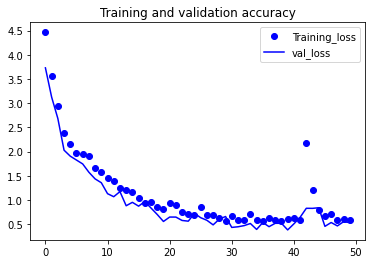

In [24]:
import matplotlib.pyplot as plt
epoch = range(0, 50)
plt.plot(epoch, data_history['loss'],'bo', label = 'Training_loss')
plt.plot(epoch, data_history['val_loss'],'b',label = 'val_loss')
plt.title('Training and validation accuracy')
plt.legend()

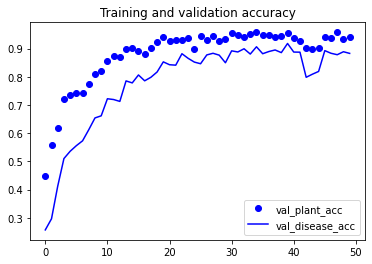

In [25]:
plt.figure()
plt.plot(epoch, data_history['val_plant_acc'],'bo', label = 'val_plant_acc')
plt.plot(epoch, data_history['val_disease_acc'],'b',label = 'val_disease_acc')
plt.title('Training and validation accuracy')
plt.legend()

In [ ]:
#pip install numpy

## test evaluate

In [26]:
with tf.device('/GPU:0'):
    score = model.evaluate_generator(test_generator, 
                             32, max_queue_size=10, workers=1, use_multiprocessing=False)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [27]:
score

[0.5285468101501465,
 0.18033571541309357,
 0.34821102023124695,
 0.9365234375,
 0.8828125]

In [28]:
print('Test loss : ', score[0])
print('Test plant_accuary : ', score[3])
print('Test disease_accuary : ', score[4])

Test loss :  0.5285468101501465
Test plant_accuary :  0.9365234375
Test disease_accuary :  0.8828125


In [29]:
#https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221343373342&proxyReferer=https:%2F%2Fwww.google.com%2F

In [30]:
batch_size = 32
steps = test_generator.samples / batch_size
predictions = model.predict_generator(test_generator, steps,)

Instructions for updating:
Please use Model.predict, which supports generators.
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_111219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


In [31]:
predictions[0]

array([[5.4313680e-34, 1.7224805e-33, 8.2822265e-34, ..., 4.9325814e-11,
        3.9076826e-34, 3.1207113e-03],
       [6.4049882e-10, 1.2633075e-09, 7.3318795e-10, ..., 8.9097191e-03,
        1.0584561e-09, 7.5711489e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.2077523e-10,
        0.0000000e+00, 2.2360930e-02],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 3.4339615e-31],
       [1.7214553e-09, 2.7080280e-09, 7.0884593e-10, ..., 4.9904313e-02,
        1.7911744e-09, 7.6663882e-01],
       [1.4893965e-30, 9.5473711e-30, 8.5765106e-30, ..., 1.2986829e-08,
        1.2106676e-30, 2.1839116e-03]], dtype=float32)

In [32]:
predictions[0][1]

array([6.4049882e-10, 1.2633075e-09, 7.3318795e-10, 5.4408860e-04,
       4.2849709e-03, 2.0831269e-01, 1.0595469e-09, 1.9112745e-02,
       1.3418696e-03, 6.8351580e-10, 3.7904942e-04, 8.9097191e-03,
       1.0584561e-09, 7.5711489e-01], dtype=float32)

In [33]:
predictions[1]

array([[8.04573809e-32, 9.99801219e-01, 1.60453499e-06, ...,
        2.67960854e-09, 1.57766565e-32, 1.03688274e-06],
       [1.98830175e-09, 1.53697491e-01, 1.00332996e-04, ...,
        4.76092726e-01, 8.42481362e-10, 2.52382886e-02],
       [0.00000000e+00, 1.68597829e-12, 1.77334146e-20, ...,
        2.37092057e-13, 0.00000000e+00, 1.26773669e-09],
       ...,
       [0.00000000e+00, 1.12137702e-26, 3.41089938e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.98286248e-09, 2.76116759e-01, 1.90800652e-04, ...,
        2.78535932e-01, 2.32674391e-09, 1.86236858e-01],
       [9.01407436e-28, 9.99167323e-01, 1.54713155e-06, ...,
        8.07835590e-07, 1.15565607e-28, 7.08196720e-04]], dtype=float32)

In [34]:
import numpy as np
a= np.argmax(predictions[0], axis=1).reshape(-1,1)
b= np.argmax(predictions[1], axis=1).reshape(-1,1)

In [35]:
a # 식물에 대해 예측

array([[ 7],
       [13],
       [ 8],
       ...,
       [ 4],
       [13],
       [ 7]], dtype=int64)

In [36]:
b #병충해에 대해 예측 

array([[ 1],
       [18],
       [ 9],
       ...,
       [ 7],
       [18],
       [ 1]], dtype=int64)

In [37]:
test['pred_plant'] = a

test['pred_disease'] = b
boolvec = ((test['plant']) == (test['pred_plant'])) & ((test['disease']) == (test['pred_disease']))
boolvec = boolvec.tolist()
boolvec.count(True)/len(boolvec) #식물과 병충해를 동시에 정확히 예측한 비율

0.86

target size가 100,100,3일때는 정확도가 79%정도였지만

target size를 224,224,3일때는 정확도가 86%로 7%정도 올라감

결론 : target size가 정확도에 중요한 영향을 미친다.